# Difference-in-Differences (DiD) Analysis: Impact of Platform Bug on User Retention
(Designed to uncover whether a platform bug led to a meaningful decline in user retention and engagement.)

### 1. Experiment Goal
**Overview:** Investigate **post-crash user retention trends** to assess the impact on **onboarding and long-term engagement**, and guide recovery strategies.


**Context:** In early April 2020, a suspected platform bug caused lessons to be completed in **less than 5 seconds**; raising concerns about data integrity and user experience. 

- March: 746 new data-analyst users
- April: 345 new users
- May: Just 6 new users

Also observed: a drop in average time between lessons; initially counterintuitive, but likely driven by lower user activity rather than increased engagement.

**Hypothesis:** We hypothesize that this bug disrupted learning behavior, leading to lower user retention and **fewer active learning days** per week. 

### 2. Map the User Journey & Behavior Funnel

Affected cohort may have experienced: Buggy lesson completions → Confusion or dissatisfaction → Lower likelihood of returning

Funnel: First Lesson → Time to Next Lesson → Lesson 2 Completion → Ongoing Engagement → Course Completion

### 3. Define Metrics

**Primary Metric:** Average Weekly Active Learning Days per User (The average number of unique days a student engages with the learning platform in a week)

**Secondary Metrics:** 
- Number of New Users per Cohort Month (Cohort-based onboarding rate)

- Average Time Between First and Second Lessons (Engagement Proxy)

- Total Active Users in Weeks 2–4 (Long-term engagement check)

**Guardrail Metrics:**

- Abnormally Fast Lesson Completions (< 30 seconds)

- Support Ticket Volume and Flagged Submissions

### Methodology: Difference-in-Differences (DiD)

**Why DiD?**  
Since we didn’t randomly assign the bug, we use DiD to compare **pre/post changes** between affected (treatment) and unaffected (control) groups.

**Setup:**
- **Treatment Group**: Users who started in **April 2020** (exposed to bug)
- **Control Group**: Users who started in **March 2020** (clean experience)

**Time Periods**
- **Pre-period**: March 2020
- **Post-period**: April–May 2020
  
- **Metric**: Weekly active learning days per user

**Assumptions:** 
- Parallel engagement trends existed pre-bug across both cohorts
- No other major product or marketing changes impacted only April users

**1. Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

lessons = pd.read_csv(r"C:\Users\Ellen\Desktop\TripleTen Task\lesson_index_test.csv")
completions = pd.read_csv(r"C:\Users\Ellen\Desktop\TripleTen Task\finished_lesson_test.csv")

# Merge Datasets
df = completions.merge(lessons, on='lesson_id', how='left')

In [6]:
# Convert timestamps & extract time periods
df['date_created'] = pd.to_datetime(df['date_created'])
df['month'] = df['date_created'].dt.to_period('M')
df['week'] = df['date_created'].dt.to_period('W')

**2. Define Treatment vs Control Groups**

In [9]:
# Treatment = users who started in April 2020 (bug period)
# Control = users who started in March 2020 (pre-bug)
df = df[df['profession_name'] == 'data-analyst']

# Get first lesson per user to define cohort
first_lesson = df.groupby('user_id')['date_created'].min().reset_index()
first_lesson['cohort_month'] = first_lesson['date_created'].dt.to_period('M')

# Merge cohort info back
df = df.merge(first_lesson[['user_id', 'cohort_month']], on='user_id', how='left')

In [11]:
# Filter cohorts of interest: March and April 2020
df = df[df['cohort_month'].isin([pd.Period('2020-03'), pd.Period('2020-04')])]
df['treatment_group'] = df['cohort_month'] == pd.Period('2020-04')

In [13]:
# Weekly Active Learning Days per Student
weekly = df.groupby(['user_id', 'treatment_group', 'week']) \
           .agg(active_days=('date_created', lambda x: x.dt.date.nunique())) \
           .reset_index()

# Define Pre and Post Periods
weekly['week_start'] = weekly['week'].dt.start_time
weekly['post'] = weekly['week_start'] >= pd.to_datetime('2020-04-01')

In [15]:
# Create DiD Interaction Term
weekly['interaction'] = weekly['post'] & weekly['treatment_group']

**3. Run Difference-in-Differences Regression**

In [19]:
model = smf.ols('active_days ~ treatment_group + post + interaction', data=weekly).fit()
print(model.summary())

summary_table = weekly.groupby(['treatment_group', 'post'])['active_days'].mean().reset_index()
summary_table['group'] = summary_table['treatment_group'].map({True: 'Treatment', False: 'Control'})
summary_table['period'] = summary_table['post'].map({True: 'Post', False: 'Pre'})
summary_table = summary_table[['group', 'period', 'active_days']]
print(summary_table)

                            OLS Regression Results                            
Dep. Variable:            active_days   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     842.3
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:46:42   Log-Likelihood:                -5884.8
No. Observations:                4980   AIC:                         1.178e+04
Df Residuals:                    4976   BIC:                         1.180e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

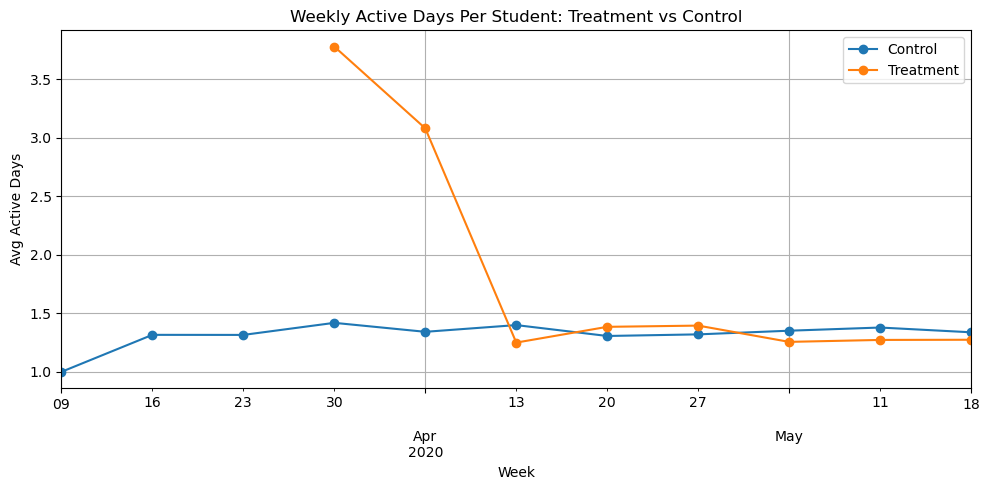

In [21]:
# Plot Engagement Trends
pivot_table = weekly.groupby(['week_start', 'treatment_group'])['active_days'].mean().unstack()
pivot_table.columns = ['Control', 'Treatment']
pivot_table.plot(figsize=(10, 5), marker='o')
plt.title("Weekly Active Days Per Student: Treatment vs Control")
plt.xlabel("Week")
plt.ylabel("Avg Active Days")
plt.grid(True)
plt.tight_layout()
plt.show()

**Regression Results**


| Coefficient              | Estimate | P-Value | Interpretation |
|--------------------------|----------|---------|----------------|
| `treatment_group`        | +2.45    | 0.000   | April users were more active **before** the bug |
| `post`                   | +0.02    | 0.38    | Overall change in control group after April |
| `interaction (DiD term)` | **-1.84**| 0.000   | **Significant drop** in engagement due to bug |

**DiD Estimate**:  
> April users experienced **1.84 fewer active learning days/week**, compared to March users, after the suspected bug.

### 4. Discuss Trade-offs

**Pros**

- Real-world behavior: No artificial testing setup — reflects natural user experience.
- Causal insight without randomization: DiD helps isolate the effect of the bug.
- Post-crash strategy: Informs recovery plans and feature quality checks.

**Risks**

- Assumes similar pre-bug trends across groups — if violated, bias can occur.
- External factors (e.g. seasonality) may confound results.
- Measurement noise: Bugs or tracking gaps could skew behavior signals.

**Mitigation**

- Use guardrail metrics like flagged completions and support tickets.
- Cross-validate with multiple metrics for consistency.
- Segment analysis by cohort or track to localize or generalize findings.

### Conclusion

- March (control) users had **stable engagement** across weeks.
- April (treatment) users had a **sharp drop** after week 1 — right after the suspected bug.
- This supports a **causal interpretation**: the crash **negatively impacted onboarding and retention**.
  
This validates our hypothesis and highlights the **business risk of platform instability.**

### Recommendations

- Audit April bug logs and address any lingering technical issues.
- Launch re-engagement campaigns for April users affected by the crash.
- Strengthen post-release regression tests to catch similar anomalies early.